# 모델 튜닝 & 결과저장

In [14]:
import time
import joblib
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score

from xgboost import XGBRegressor
from xgboost import XGBClassifier

from scipy.stats import boxcox
from scipy.special import boxcox1p

import tensorflow.keras as keras
import tensorflow as tf

import optuna

import plotly

## data1 : Regression Model

## data2 : Binary-classification Model

## data3 : Multi-classification Model

### 데이터 불러오기 및 함수 정의

In [56]:
# preprocessing.ipynb의 결과에 따라 전처리
# 함수로 만들어서 진행 : multiple_load_dataset()

def multiple_load_dataset(tf_dataset=False):
    """
    data3을 불러와서 전처리된 데이터셋을 반환
    전처리:  
    1. A400컬럼 드랍 drop
    2. 범주형 원핫인코딩
    3. 수치형 표준화

    args:
        tf_dataset : True인경우 tf.Dataset 반환
    
    returns:
        if tf_dataset is True : train_ds, valid_ds
        if tf_dataset if False : X_train, X_test, y_train, y_test
    """
    
    # 추후 ct를 불러오기위해 전역변수로 설정
    global data3_ct

    df3 = pd.read_csv('data/mulit_classification_data.csv')

    # A300과 A400의 상관계수 1 => A400컬럼 제거 
    target = df3.loc[:,'Pastry':'Other_Faults'].columns
    X = df3.drop(columns='TypeOfSteel_A400')
    X = X.drop(columns=target, axis=1)
    y = df3[target].copy()
    y['label'] = np.argmax(y.values, axis=1) # label구분을 위한 컬럼추가

    # 범주형 : TypeOfSteel_A300, Outside_Global_Index
    cat_cols = ['TypeOfSteel_A300', 'Outside_Global_Index']
    num_cols = list(X.drop(columns=cat_cols))

    # 범주형 ohe, 나머지 표준화
    data3_ct = make_column_transformer(
        (StandardScaler(), num_cols),
        (OneHotEncoder(sparse_output=False, drop='if_binary'), cat_cols),
        remainder='passthrough'
    )
    data3_ct.set_output(transform='pandas')

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.25,
                                                        stratify=y['label'],
                                                        random_state=42)
    # 독립변수 28개, 종속변수 7개
    X_train = data3_ct.fit_transform(X_train)
    X_test = data3_ct.transform(X_test)

    if tf_dataset:
        train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train.drop('label', axis=1)))
        valid_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test.drop('label', axis=1)))

        train_ds = train_ds.cache().shuffle(2000).batch(32)
        valid_ds = valid_ds.cache().batch(32)
        return train_ds, valid_ds
    else:
        return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = multiple_load_dataset()
y_true = y_test.drop('label', axis=1)

# modelA 데이터 (Other_Faults 0, 1 라벨)
y_trainA = y_train.Other_Faults
y_testA = y_test.Other_Faults

# modelB 데이터 (Other_Faults제외 6개 결함 라벨)
y_trainB = y_train[y_train.Other_Faults == 0].label
y_testB = y_test[y_test.Other_Faults == 0].label
X_trainB = X_train.loc[y_trainB.index]
X_testB = X_test.loc[y_testB.index]

train_ds, valid_ds = multiple_load_dataset(tf_dataset=True)

In [3]:
# 콜백 정의 
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.5, patience=15,
                                                 verbose=0, mode='auto')
e_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                          patience=40,
                                          restore_best_weights=True)

def multiple_nn_prediction(model, X_valid):
    # X_valid에 valid_ds 넣으면 X_valid로 자동변환
    if isinstance(X_valid, tf.data.Dataset):
        X_valid = np.array([i for i, _ in valid_ds.unbatch()])

    pred = model.predict(X_valid, verbose=False)
    max_val = np.max(pred, axis=1, keepdims=True)
    pred = np.where(pred == max_val, 1, 0)
    return pred

def multiple_nn_performance(model, hist, valid_ds):
    
    plt.plot(hist.history['prc'], label='train')
    plt.plot(hist.history['val_prc'], label='val')
    plt.ylabel('AUCR-PR')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()
    
    y_true = np.array([i.numpy() for _, i in valid_ds.unbatch()])
    X_valid = np.array([i for i, _ in valid_ds.unbatch()])
    y_pred = multiple_nn_prediction(model, X_valid)
    target_names = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']

    print(classification_report(y_true, y_pred, target_names=target_names))

### 신경망 모델 튜닝

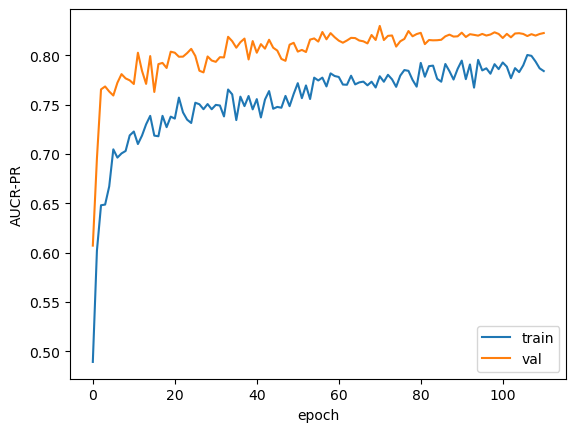

              precision    recall  f1-score   support

      Pastry       0.56      0.62      0.59        39
   Z_Scratch       0.77      0.85      0.81        48
    K_Scatch       0.97      0.95      0.96        98
      Stains       0.85      0.94      0.89        18
   Dirtiness       0.70      0.50      0.58        14
       Bumps       0.60      0.67      0.64       101
Other_Faults       0.68      0.61      0.64       168

   micro avg       0.72      0.72      0.72       486
   macro avg       0.73      0.73      0.73       486
weighted avg       0.73      0.72      0.72       486
 samples avg       0.72      0.72      0.72       486



In [53]:
# 기본모델 : 16 => 32 => 16 => 7(out)
m_model = tf.keras.Sequential([
        keras.layers.Dense(16),
        keras.layers.Dropout(0.5),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dense(32),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dense(16),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dense(7, activation='softmax')
    ])
m_model.compile(loss='categorical_crossentropy',
                  metrics=[keras.metrics.AUC(name='prc', curve='PR')],
                  optimizer=keras.optimizers.Adam(0.01))
    
hist = m_model.fit(train_ds,
                    validation_data=valid_ds,
                    epochs=200,
                    callbacks=[e_stop, reduce_lr],
                    verbose=0)

multiple_nn_performance(m_model, hist, valid_ds)
# acc ~ 0.72
# f1 ~ 0.73

In [4]:

# optuna 튜닝과정
# objective함수를 정의하하고 study를 생성합니다.
# objective함수는 각 trial마다 호출되서 trial의 suggest값이 대입됩니다.
# sutdy.optimize를 하게되면 objective의 return값을 maximize하거나 minimize 하는식으로 학습합니다.

# objective : 모델 넣고 최소화 하거나 최대화할 metric 반환
# trial : 각 시도마다 옵튜나에서 알아서 넣을 값들. 즉 튜닝대상 하이퍼파라미터
# trial종류
#   1. trial.suggest_int(name, low, high) : low부터 high까지의 정수
#   2. trial.suggest_float(name, low, high, step, log) : low부터 high까지 실수. log=True면 로그범위로 선택
# study : 최적화를 진행하고 결과를 기록하는 객체

def nn_objective(trial):
    global train_ds
    global valid_ds
    global reduce_lr
    global e_stop
    global y_true

    n_layers = trial.suggest_int('n_layers',2, 8)
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=[28,]))
    for i in range(n_layers):
        node = trial.suggest_int(f'layer{i}_node', 4, 128, log=True)
        drop_rate = trial.suggest_float(f'layer{i}_dropout', 0.3, 0.9, step=0.1)
        model.add(keras.layers.Dense(node))
        model.add(keras.layers.Dropout(drop_rate))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.ReLU())
    model.add(keras.layers.Dense(7, activation='softmax'))

    lr = trial.suggest_float('eta', 1e-4, 1e-2, log=True)
    model.compile(loss='categorical_crossentropy',
                  metrics=[keras.metrics.AUC(name='prc', curve='PR')],
                  optimizer=keras.optimizers.Adam(0.01))
    
    hist = model.fit(train_ds,
                     validation_data=valid_ds,
                     epochs=300,
                     callbacks=[e_stop, reduce_lr],
                     verbose=0)
    
    y_pred = multiple_nn_prediction(model, valid_ds)
    micro_f1 = f1_score(y_true, y_pred, average='micro')

    return micro_f1

study = optuna.create_study(direction='maximize')
study.optimize(nn_objective, n_trials=500)

joblib.dump(study, 'multiple_nn_tuning.pkl')

[I 2023-07-25 01:16:49,800] A new study created in memory with name: no-name-85e6f767-526a-4f4e-b5e0-c93a6fb47c9e
[I 2023-07-25 01:17:20,434] Trial 0 finished with value: 0.345679012345679 and parameters: {'n_layers': 7, 'layer0_node': 6, 'layer0_dropout': 0.9, 'layer1_node': 5, 'layer1_dropout': 0.8, 'layer2_node': 80, 'layer2_dropout': 0.7, 'layer3_node': 33, 'layer3_dropout': 0.7, 'layer4_node': 25, 'layer4_dropout': 0.5, 'layer5_node': 20, 'layer5_dropout': 0.7, 'layer6_node': 70, 'layer6_dropout': 0.5, 'eta': 0.0013372017741762252}. Best is trial 0 with value: 0.345679012345679.
[I 2023-07-25 01:17:35,657] Trial 1 finished with value: 0.5082304526748971 and parameters: {'n_layers': 3, 'layer0_node': 5, 'layer0_dropout': 0.8, 'layer1_node': 82, 'layer1_dropout': 0.5, 'layer2_node': 34, 'layer2_dropout': 0.8, 'eta': 0.0004492775332575892}. Best is trial 1 with value: 0.5082304526748971.
[I 2023-07-25 01:17:53,213] Trial 2 finished with value: 0.4053497942386831 and parameters: {'n_l

['nn_tuning.pkl']

In [4]:
# if os.path.exists('multiple_nn_tuning.pkl'):
#     study = joblib.load('multiple_nn_tuning.pkl')
    
print(f'best f1 : {study.best_trial.value}\nbest params : {study.best_trial.params}')
optuna.visualization.plot_optimization_history(study)

best f1 : 0.7736625514403292
best params : {'n_layers': 2, 'layer0_node': 108, 'layer0_dropout': 0.3, 'layer1_node': 7, 'layer1_dropout': 0.3, 'eta': 0.0021096691683225853}


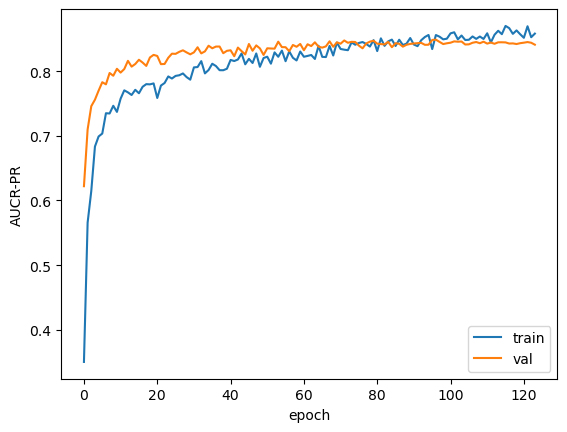

              precision    recall  f1-score   support

      Pastry       0.59      0.62      0.60        39
   Z_Scratch       0.84      0.85      0.85        48
    K_Scatch       0.98      0.96      0.97        98
      Stains       1.00      0.94      0.97        18
   Dirtiness       0.67      0.57      0.62        14
       Bumps       0.62      0.69      0.65       101
Other_Faults       0.69      0.65      0.67       168

   micro avg       0.75      0.75      0.75       486
   macro avg       0.77      0.76      0.76       486
weighted avg       0.75      0.75      0.75       486
 samples avg       0.75      0.75      0.75       486



In [12]:
def multiple_nn_bestmodel(trial):
    global train_ds
    global valid_ds
    global reduce_lr
    global e_stop
    global y_true

    n_layers = trial.suggest_int('n_layers',2, 8)
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=[28,]))
    for i in range(n_layers):
        node = trial.suggest_int(f'layer{i}_node', 4, 128, log=True)
        drop_rate = trial.suggest_float(f'layer{i}_dropout', 0.3, 0.9, step=0.1)
        model.add(keras.layers.Dense(node))
        model.add(keras.layers.Dropout(drop_rate))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.ReLU())
    model.add(keras.layers.Dense(7, activation='softmax'))

    lr = trial.suggest_float('eta', 1e-4, 1e-2, log=True)
    model.compile(loss='categorical_crossentropy',
                  metrics=[keras.metrics.AUC(name='prc', curve='PR')],
                  optimizer=keras.optimizers.Adam(0.01))
    
    hist = model.fit(train_ds,
                     validation_data=valid_ds,
                     epochs=300,
                     callbacks=[e_stop, reduce_lr],
                     verbose=0)
    return model, hist
    
m_model2, hist = multiple_nn_bestmodel(study.best_trial)
multiple_nn_performance(m_model2, hist, valid_ds)

# 신경망 모델의 성능이 생각보다 높지 않다.

### XGBoost 튜닝

In [138]:
from sklearn.utils.class_weight import compute_sample_weight



array([0.5403868 , 0.5403868 , 0.5403868 , 0.5403868 , 0.5403868 ,
       0.52602436, 3.86178862, 0.5403868 , 0.5403868 , 0.5403868 ,
       1.33053221, 0.52602436, 0.5403868 , 1.11502347, 1.11502347,
       0.5403868 , 0.52602436, 0.52602436, 0.5403868 , 0.52602436,
       1.11502347, 0.52602436, 1.33053221, 1.33053221, 1.33053221,
       1.33053221, 0.52602436, 1.33053221, 0.5403868 , 0.5403868 ,
       1.11502347, 1.33053221, 1.33053221, 1.11502347, 1.11502347,
       1.33053221, 0.5403868 , 0.5403868 , 1.11502347, 0.52602436,
       0.52602436, 0.52602436, 0.5403868 , 2.93209877, 2.93209877,
       0.52602436, 0.52602436, 1.11502347, 0.5403868 , 1.33053221,
       0.52602436, 0.52602436, 1.11502347, 0.52602436, 2.93209877,
       0.5403868 , 0.5403868 , 0.52602436, 1.11502347, 0.52602436,
       0.52602436, 1.33053221, 0.52602436, 0.5403868 , 3.86178862,
       1.33053221, 0.52602436, 0.52602436, 0.5403868 , 2.93209877,
       0.52602436, 1.33053221, 0.5403868 , 0.52602436, 1.11502

In [144]:
# Other_Faults 분리해서 xgboost로 튜닝
# 첫 번째 모델 (modelA): Other_Faults인지 아닌지 분류
# 두 번째 모델 (modelB): Other_Faults가 아니면 다중분류

def multiple_xgb_model(trial, X_train, X_test, y_train, y_test, case='A'):
    model_params = {
        'learning_rate':trial.suggest_float('learning_rate', 0.0001, 1.0, log=True),
        'n_estimators':trial.suggest_int('n_estimators', 100, 2000, step=10),
        'max_depth':trial.suggest_int('max_depth', 4, 20),
        'colsample_bytree':trial.suggest_float('colsample_bytree', 0.2, 1.0, step=0.1),
        'reg_lambda':trial.suggest_float('l2', 0.001, 100.0, log=True),
        'reg_alpha':trial.suggest_float('l1', 0.001, 100.0, log=True),
        'gamma':trial.suggest_float('gamma', 0.001, 100.0, log=True),
    }
    # 이진분류 케이스
    if case == 'A':
        # 파라미터 scalse_pos_weight 추가
        model_params['scale_pos_weight'] = trial.suggest_float('scale_pos_weight', 1.0, 5.0, step=0.1)

        multiple_xgb_modelA = XGBClassifier(random_state=42,
                                            objective='binary:logistic',
                                            eval_metric='error',
                                            tree_method='gpu_hist',
                                            gpu_id=0,
                                            early_stopping_rounds=30,
                                            **model_params)
        
        multiple_xgb_modelA.fit(X_train, y_train,
                                eval_set=[(X_test, y_test)],
                                verbose=0)
        
        return multiple_xgb_modelA
    # 다중분류 케이스
    elif case == 'B':
        # 다중분류는 scale_pos_weight 설정이 불가함으로 sklearn을 활용,
        # sample weight로 weight 설정
        weight = compute_sample_weight(class_weight='balanced', y=y_trainB)

        multiple_xgb_modelB = XGBClassifier(random_state=42,
                                            objective='multi:softprob',
                                            eval_metric='aucpr',
                                            tree_method='gpu_hist',
                                            gpu_id=0,
                                            early_stopping_rounds=30,
                                            num_class=6,
                                            **model_params)
        
        multiple_xgb_modelB.fit(X_train, y_train,
                                eval_set=[(X_test, y_test)],
                                sample_weight=weight,
                                verbose=0)
        
        return multiple_xgb_modelB


def multiple_xgb_objective(trial, X_train, X_test, y_train, y_test, case='A'):
    
    model = multiple_xgb_model(trial, X_train, X_test, y_train, y_test, case)
    
    if case == 'A':
        acc = accuracy_score(y_test, model.predict(X_test))
        return acc
    elif case == 'B':
        micro_f1 = f1_score(y_test, model.predict(X_test), average='micro')
        return micro_f1


# multiple_modelA_study = optuna.create_study(
#     direction='maximize',
#     sampler=optuna.samplers.TPESampler()
# )

# multiple_modelA_study.optimize(
#     lambda trial: multiple_xgb_objective(trial, X_train, X_test, y_trainA, y_testA, case='A'),
#     n_trials=2000
# )

# joblib.dump(multiple_modelA_study, 'multiple_modelA_tuning.pkl')

In [145]:
if os.path.exists('multiple_modelA_tuning.pkl'):
    multiple_modelA_study = joblib.load('multiple_modelA_tuning.pkl')
    
print(f'best acc : {multiple_modelA_study.best_trial.value}\nbest params : {multiple_modelA_study.best_trial.params}')

multiple_modelA = multiple_xgb_model(multiple_modelA_study.best_trial, X_train, X_test, y_trainA, y_testA)
print(classification_report(y_testA, multiple_modelA.predict(X_test)))

optuna.visualization.plot_optimization_history(multiple_modelA_study)

best acc : 0.8436213991769548
best params : {'learning_rate': 0.012202469692864067, 'n_estimators': 700, 'max_depth': 11, 'colsample_bytree': 0.7, 'l2': 0.6998936289657887, 'l1': 0.07423629936782049, 'gamma': 0.04343495370664839, 'scale_pos_weight': 1.2}
              precision    recall  f1-score   support

           0       0.85      0.93      0.89       318
           1       0.83      0.68      0.75       168

    accuracy                           0.84       486
   macro avg       0.84      0.81      0.82       486
weighted avg       0.84      0.84      0.84       486



In [ ]:
multiple_modelB_study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler()
)

multiple_modelB_study.optimize(
    lambda trial: multiple_xgb_objective(trial, X_trainB, X_testB, y_trainB, y_testB, case='B'),
    n_trials=1000
)

joblib.dump(multiple_modelB_study, 'multiple_modelB_tuning.pkl')

In [147]:
# if os.path.exists('multiple_modelB_tuning.pkl'):
#     multiple_modelA_study = joblib.load('multiple_modelB_tuning.pkl')
    
print(f'best acc : {multiple_modelB_study.best_trial.value}\nbest params : {multiple_modelB_study.best_trial.params}')

multiple_modelB = multiple_xgb_model(multiple_modelB_study.best_trial, X_trainB, X_testB, y_trainB, y_testB, case='B')
print(classification_report(y_testB, multiple_modelB.predict(X_testB)))

optuna.visualization.plot_optimization_history(multiple_modelB_study)
# 결과가 상당히 괜찮게 나왔다!

best acc : 0.9339622641509434
best params : {'learning_rate': 0.07522487380833985, 'n_estimators': 250, 'max_depth': 4, 'colsample_bytree': 0.6000000000000001, 'l2': 0.001648272236870337, 'l1': 0.01657588037413299, 'gamma': 0.002792373320363197}
              precision    recall  f1-score   support

           0       0.77      0.87      0.82        39
           1       0.94      1.00      0.97        48
           2       0.99      0.99      0.99        98
           3       1.00      0.94      0.97        18
           4       1.00      0.79      0.88        14
           5       0.93      0.89      0.91       101

    accuracy                           0.93       318
   macro avg       0.94      0.91      0.92       318
weighted avg       0.94      0.93      0.93       318



### 튜닝결과

* XGBoost 채용
* 이진분류 acc : 0.844
* 다중분류 micro-f1 : 0.934